<a href="https://colab.research.google.com/github/monicafar147/regression-predict-api-template/blob/monique2/final_ZINDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction


The aim of this notebook is to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination from a logistics company, Sendy, based in Nairobi.

Sendy can improve their reliability and enhance their customer communication by providing an estimated time of delivery of orders through regression techniques used to model the delivery process.

Sendy is headquartered in Kenya and the data provided is based in Nairobi. The training dataset provided is a subset of over 21201 orders and only includes direct orders (i.e. Sendy “express” orders) with bikes in Nairobi.

#Body

## Imports

###Importing the libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import math
from pprint import pprint
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Scaling
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

# Saving model with pickle
import pickle

sns.set(palette='pastel')

### Importing the data

In [0]:
train = pd.read_csv('https://raw.githubusercontent.com/monicafar147/regression-predict-api-template/master/Train.csv', index_col=0)
test = pd.read_csv('https://raw.githubusercontent.com/monicafar147/regression-predict-api-template/master/Test.csv', index_col=0)
riders = pd.read_csv('https://raw.githubusercontent.com/monicafar147/regression-predict-api-template/master/Riders.csv', index_col=0)

##EDA

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21201 entries, Order_No_4211 to Order_No_9836
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   User Id                                    21201 non-null  object 
 1   Vehicle Type                               21201 non-null  object 
 2   Platform Type                              21201 non-null  int64  
 3   Personal or Business                       21201 non-null  object 
 4   Placement - Day of Month                   21201 non-null  int64  
 5   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 6   Placement - Time                           21201 non-null  object 
 7   Confirmation - Day of Month                21201 non-null  int64  
 8   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 9   Confirmation - Time                        21201 non-null  object 
 10  Arrival

### Converting time columns into datetime

In [0]:
train['Pickup - Time'] = pd.to_datetime(train['Pickup - Time']).dt.time
train['Placement - Time'] = pd.to_datetime(train['Placement - Time']).dt.time
train['Confirmation - Time'] = pd.to_datetime(train['Confirmation - Time']).dt.time
train['Arrival at Pickup - Time'] = pd.to_datetime(train['Arrival at Pickup - Time']).dt.time
train['Arrival at Destination - Time'] = pd.to_datetime(train['Arrival at Destination - Time']).dt.time

At this stage, we notice that there are missing values from `Temperature` and `Precipitation in millimeters`.

In [40]:
train.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,23.258889,7.905797,-1.281470,36.811264,-1.282581,36.811220,1556.920947
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.615768,17.089971,0.030507,0.037473,0.034824,0.044721,987.270788
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.200000,0.100000,-1.438302,36.653621,-1.430298,36.606594,1.000000
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.075000,-1.300921,36.784605,-1.301201,36.785661,882.000000
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.500000,2.900000,-1.279395,36.807040,-1.284382,36.808002,1369.000000
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,26.000000,4.900000,-1.257147,36.829741,-1.261177,36.829477,2040.000000
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,32.100000,99.100000,-1.147170,36.991046,-1.030225,37.016779,7883.000000


Change the column names to remove unnecesarry white space.

In [41]:
train.columns = [col.replace("-"," ") for col in train.columns]
train.columns = [col.replace("(Mo = 1)"," ") for col in train.columns]
train.columns = [col.replace(" ","") for col in train.columns]

train.head()

,UserId,VehicleType,PlatformType,PersonalorBusiness,PlacementDayofMonth,PlacementWeekday,PlacementTime,ConfirmationDayofMonth,ConfirmationWeekday,ConfirmationTime,ArrivalatPickupDayofMonth,ArrivalatPickupWeekday,ArrivalatPickupTime,PickupDayofMonth,PickupWeekday,PickupTime,ArrivalatDestinationDayofMonth,ArrivalatDestinationWeekday,ArrivalatDestinationTime,Distance(KM),Temperature,Precipitationinmillimeters,PickupLat,PickupLong,DestinationLat,DestinationLong,RiderId,TimefromPickuptoArrival
Order No,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Order_No_4211,User_Id_633,Bike,3,Business,9,5,09:35:46,9,5,09:40:10,9,5,10:04:47,9,5,10:27:30,9,5,10:39:55,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16,12,5,11:23:21,12,5,11:40:22,12,5,11:44:09,12,5,12:17:22,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25,30,2,12:42:44,30,2,12:49:34,30,2,12:53:03,30,2,13:00:38,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
Order_No_9336,User_Id_1402,Bike,3,Business,15,5,09:25:34,15,5,09:26:05,15,5,09:37:56,15,5,09:43:06,15,5,10:05:27,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,09:55:18,13,1,09:56:18,13,1,10:03:53,13,1,10:05:23,13,1,10:25:37,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


### Distribution of Target Variable

Text(0.5, 1.0, 'Delivery Time Distribution')

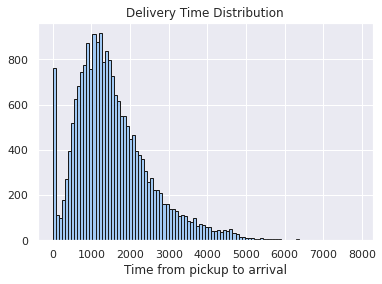

In [42]:
plt.hist(train['TimefromPickuptoArrival'], bins = 100, edgecolor = 'k')
plt.xlabel('Time from pickup to arrival') 
plt.title('Delivery Time Distribution')

The high distribution of very low values seems suspicious.

In [43]:
print('Time from pickup to arrival less than 60s:', len(train[train['TimefromPickuptoArrival'] < 60]))
print('Time from pickup to arrival of 1s: ', len(train[train['TimefromPickuptoArrival'] ==1]))

Time from pickup to arrival less than 60s: 740
Time from pickup to arrival of 1s:  37


`Time from pickup to arrival` of less than 60 seconds seems suspicious, especially 1 second. It is possible that riders may have forgotten to confirm the pickup on the app until they dropped off the parcel, resulting in this unrealistic time frame. These rows should be dropped because they will skew the data.

Text(0.5, 1.0, 'Delivery Time Distribution')

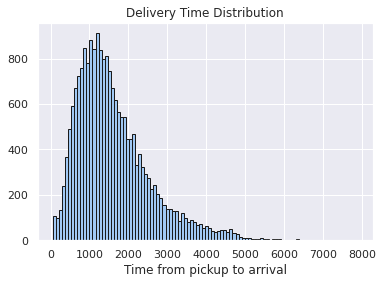

In [44]:
# Dropping rows where delivery time is less than 60s
orders = train[train['TimefromPickuptoArrival'] > 60]

# Plotting the new target variable distribution
plt.hist(orders['TimefromPickuptoArrival'], bins = 100, edgecolor = 'k')
plt.xlabel('Time from pickup to arrival') 
plt.title('Delivery Time Distribution')

###Cumulative Distribution Function for Distances and Delivery Times

Text(0.5, 1.0, 'ECDF Plot for Delivery Time')

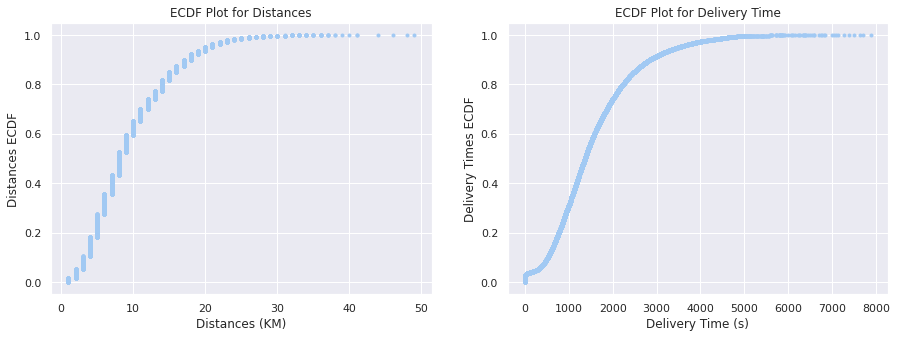

In [45]:
distances = np.sort(train['Distance(KM)'])
distances_ecdf = np.arange(1, len(distances) + 1) / len(distances)
delivery_times = np.sort(train['TimefromPickuptoArrival'])
delivery_times_ecdf = np.arange(1, len(delivery_times) + 1) / len(delivery_times)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(distances, distances_ecdf, marker='.', linestyle='none')
ax1.set_xlabel('Distances (KM)')
ax1.set_ylabel('Distances ECDF')
ax1.set_title('ECDF Plot for Distances')

ax2.plot(delivery_times, delivery_times_ecdf, marker='.', linestyle='none')
ax2.set_xlabel('Delivery Time (s)')
ax2.set_ylabel('Delivery Times ECDF')
ax2.set_title('ECDF Plot for Delivery Time')

We can see that 60 and 95 percent of deliveries are within 10KM and 20KM respectively.


With the time distributions we see that 60 and 95 percent of the delivery times are within approximately 1500(s) and 3000(s)

### Exploring Day of Month Columns

By just eyeing the first few rows of the data, it seems that the order might tend to be picked up on the same day that the order was placed, which makes sense considering this is an express delivery service.

In [46]:
# Creating a column that calculates the difference between when the
# order was made and when the order was picked up
train['placement_pickup'] = train['PickupDayofMonth'] - train['PlacementDayofMonth']
print(train[train['placement_pickup'] > 0])

# Dropping the calculated column
train.drop(['placement_pickup'], axis=1, inplace=True)

                     UserId  ... placement_pickup
Order No                     ...                 
Order_No_2800  User_Id_1402  ...                1
Order_No_3530  User_Id_2457  ...                2

[2 rows x 29 columns]


It seems that there have only been two cases when the order was made and picked up on different days (and the difference was only one or two days). Out of 21201 rows of data, this data seems that it will have minor predictive capabilities.

It can therefore be suggested that when training the model, we only include one Day of Week and Day of Month column because including they will have high multicollinearity with each other.

### Exploring Distributions on Different Days

In [0]:
# Converting relevant columns into categorical data types
train['VehicleType'] = train['VehicleType'].astype('category')
train['PlatformType'] = train['PlatformType'].astype('category')
train['PersonalorBusiness'] = train['PersonalorBusiness'].astype('category')

train['PlacementDayofMonth'] = train['PlacementDayofMonth'].astype('category')
train['PlacementWeekday'] = train['PlacementWeekday'].astype('category')
train['ConfirmationDayofMonth'] = train['ConfirmationDayofMonth'].astype('category')
train['ConfirmationWeekday'] = train['ConfirmationWeekday'].astype('category')

train['ArrivalatPickupDayofMonth'] = train['ArrivalatPickupDayofMonth'].astype('category')
train['ArrivalatPickupWeekday'] = train['ArrivalatPickupWeekday'].astype('category')
train['ArrivalatDestinationDayofMonth'] = train['ArrivalatDestinationDayofMonth'].astype('category')
train['ArrivalatDestinationWeekday'] = train['ArrivalatDestinationWeekday'].astype('category')

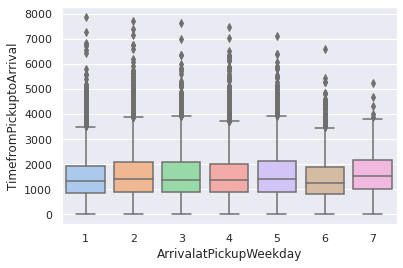

In [48]:
sns.boxplot(x='ArrivalatPickupWeekday', y='TimefromPickuptoArrival', data=train)

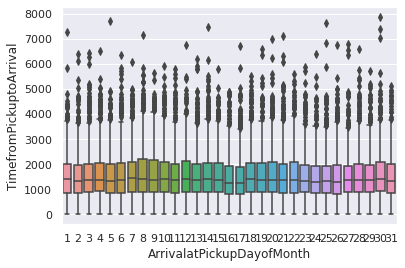

In [49]:
sns.boxplot(x='ArrivalatPickupDayofMonth', y='TimefromPickuptoArrival', data=train)

These boxplots indicate that there doesn't seem to be a huge difference in travel time between the different days. There are quite a number of outliers in each day's category.

### Correlations

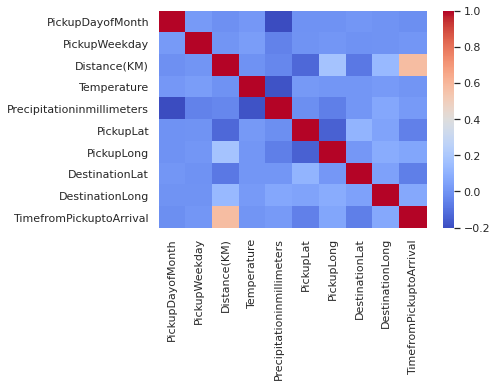

In [50]:
train_corr = train.corr()
sns.heatmap(train_corr, cmap='coolwarm')

##Data preprocessing


### Splitting into training features and outputs

In [0]:
training_features = orders.iloc[:, :-1]
training_outputs = orders.iloc[:, -1]

### Converting features into categories

1. Pickup - Day of Month
2. Pickup - Weekday (Mo = 1)
3. Platform Type
4. Personal or Business

In [0]:
training_features[['PickupDayofMonth', 'PickupWeekday']] = training_features[['PickupDayofMonth', 'PickupWeekday']].astype('category')
training_features[['PlatformType', 'PersonalorBusiness']] = training_features[['PlatformType', 'PersonalorBusiness']].astype('category')

### Selecting features to be part of training data

1. Platform Type
2. Personal or Business
3. Pickup - Day of Month
4. Pickup - Weekday (Mo = 1)
5. Pickup - Time
6. Pickup Lat
7. Pickup Long
8. Destination Lat
9. Destination Long
10. Distance (KM)
11. Temperature
12. Precipitation in millimeters

In [0]:
training_features = training_features[['PlatformType', 'PersonalorBusiness',
                                       'PickupDayofMonth', 'PickupWeekday',
                                       'PickupTime', 'PickupLat',	'PickupLong',
                                       'DestinationLat',	'DestinationLong',
                                       'Distance(KM)', 'Temperature',
                                       'Precipitationinmillimeters']]

### Create time buckets

1. Early Morning
2. Morning
3. Late Morning
4. Afternoon
5. Late Afternoon
6. Evening

In [0]:
def assign_time_category(delivery_time):
    dts = pd.DataFrame(['00:00:00', '6:00:00', '9:00:00', '12:00:00', '15:00:00', '18:00:00'])
    dts[0] = pd.to_datetime(dts[0]).dt.time
    if delivery_time >= dts[0][0] and delivery_time < dts[0][1]:
        return 'Early Morning'
    elif delivery_time >= dts[0][1] and delivery_time < dts[0][2]:
        return 'Morning'
    elif delivery_time >= dts[0][2]  and delivery_time < dts[0][3]:
        return 'Late Morning'
    elif delivery_time >= dts[0][3] and delivery_time < dts[0][4]:
        return 'Afternoon'
    elif delivery_time >= dts[0][4] and delivery_time < dts[0][5]:
        return 'Late Afternoon'
    else:
        return 'Evening'

In [0]:
# Create new time bucket feature based on assign_time_category function
training_features['DeliveryTimes'] = training_features['PickupTime'].apply(assign_time_category)
training_features['DeliveryTimes'] = training_features['DeliveryTimes'].astype('category')

# Dropping 'Pickup - Time' because we have created 'Delivery Times' in its place
training_features.drop('PickupTime', axis=1, inplace=True)

### Dealing with missing precipitation values

As described above, there are null-values present in the Temperature and Precipitation in millimeters columns.

We are assuming that if `Precipitation in millimeters` is missing, that it was not raining on that day. We can therefore fill null values with 0.

In [0]:
# Fill missing precipitation values with 0
training_features['Precipitationinmillimeters'] = training_features['Precipitationinmillimeters'].fillna(value=0)

### Dealing with missing temperature values

Going by intuition only, observing a relationship between temperature and time of day may be useful in filling in the missing temperature values. Missing temperature data will be imputed by grouping the mean temperature by the time buckets that were created above.

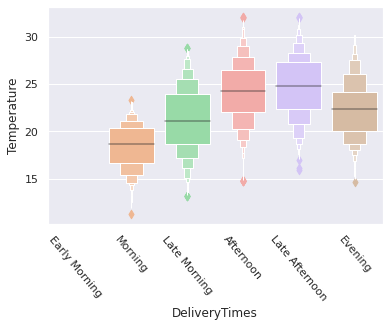

In [57]:
del_temp_plt = sns.boxenplot(y=training_features['Temperature'], 
                x=training_features['DeliveryTimes'], 
                order=["Early Morning", "Morning", "Late Morning",
                     "Afternoon", "Late Afternoon", "Evening"])
del_temp_plt = del_temp_plt.set_xticklabels(del_temp_plt.get_xticklabels(), rotation=-50)


This box plot shows us that temperatures tend to be cool in the morning and increase until the late afternoon, after which, it decreases.

In [0]:
# Function to fill nulls with a column's mean value
def mean(col):
      return col.fillna(col.mean())

In [0]:
# Impute missing temperature based on delivery time
training_features['Temperature'] = training_features.groupby(['DeliveryTimes'])['Temperature'].transform(mean)

### Calculating distance from CBD

Considering that Nairobi is one of the most congested cities in the world, considering the pickup and delivery locations' distance from Nairobi's CBD may play a role in determining how much traffic one can expect on a trip.

A coordinate of -1.283526, 36.823269 was picked to represent the middle of Nairobi's CBD.

In [0]:
# Function to calculate a coordinate's distance from the CBD coordinate
def distance_CBD(lat, long):
  return math.sqrt(((lat - -1.283526) ** 2) + ((long - 36.823269) ** 2))

In [0]:
training_features['DistanceCBDpickup'] = np.vectorize(distance_CBD)(training_features['PickupLat'],
                                    training_features['PickupLong'])
training_features['DistanceCBDdest'] = np.vectorize(distance_CBD)(training_features['DestinationLat'],
                                    training_features['DestinationLong'])

### Encoding data

In [0]:
# One-hot encoding for categorical data

training_features = pd.get_dummies(training_features,
                                   columns=['PlatformType', 'PersonalorBusiness', 'PickupDayofMonth', 'PickupWeekday', 'DeliveryTimes'],
                                   prefix=['platformtype', 'personalbusiness', 'dayofmonth', 'weekday', 'pickuptimes'])

In [63]:
training_features.head()

,PickupLat,PickupLong,DestinationLat,DestinationLong,Distance(KM),Temperature,Precipitationinmillimeters,DistanceCBDpickup,DistanceCBDdest,platformtype_1,platformtype_2,platformtype_3,platformtype_4,personalbusiness_Business,personalbusiness_Personal,dayofmonth_1,dayofmonth_2,dayofmonth_3,dayofmonth_4,dayofmonth_5,dayofmonth_6,dayofmonth_7,dayofmonth_8,dayofmonth_9,dayofmonth_10,dayofmonth_11,dayofmonth_12,dayofmonth_13,dayofmonth_14,dayofmonth_15,dayofmonth_16,dayofmonth_17,dayofmonth_18,dayofmonth_19,dayofmonth_20,dayofmonth_21,dayofmonth_22,dayofmonth_23,dayofmonth_24,dayofmonth_25,dayofmonth_26,dayofmonth_27,dayofmonth_28,dayofmonth_29,dayofmonth_30,dayofmonth_31,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,pickuptimes_Afternoon,pickuptimes_Evening,pickuptimes_Late Afternoon,pickuptimes_Late Morning,pickuptimes_Morning
Order No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Order_No_4211,-1.317755,36.830370,-1.300406,36.829741,4,20.400000,0.0,0.034958,0.018078,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
Order_No_25375,-1.351453,36.899315,-1.295004,36.814358,16,26.400000,0.0,0.101966,0.014531,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
Order_No_1899,-1.308284,36.843419,-1.300921,36.828195,3,24.164724,0.0,0.031922,0.018079,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
Order_No_9336,-1.281301,36.832396,-1.257147,36.795063,9,19.200000,0.0,0.009394,0.038619,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
Order_No_27883,-1.266597,36.792118,-1.295041,36.809817,9,15.400000,0.0,0.035454,0.017707,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


### Train-test split

A train-test split is performed within the training data with the intention of the "test" set acting as a validation set through which the models can be evaluated.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(training_features, training_outputs, test_size=0.2)

Plotting the train vs test data

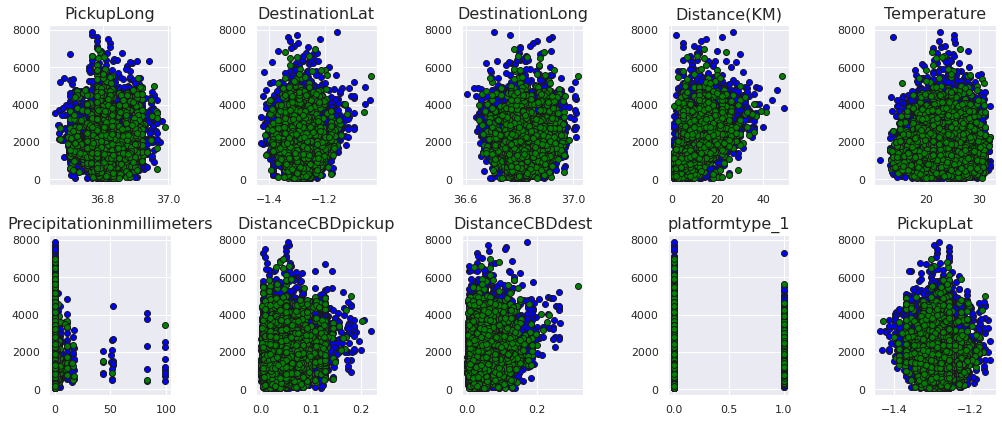

In [65]:
fig, axs = plt.subplots(2,5, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()
for index, column in enumerate(X_train.columns[0:10]):
    axs[index-1].set_title("{}".format(column),fontsize=16)
    axs[index-1].scatter(x=X_train[column],y=y_train,color='blue',edgecolor='k',label='Training')
    axs[index-1].scatter(x=X_test[column],y=y_test,color='green',edgecolor='k',label='Testing')
fig.tight_layout(pad=1)

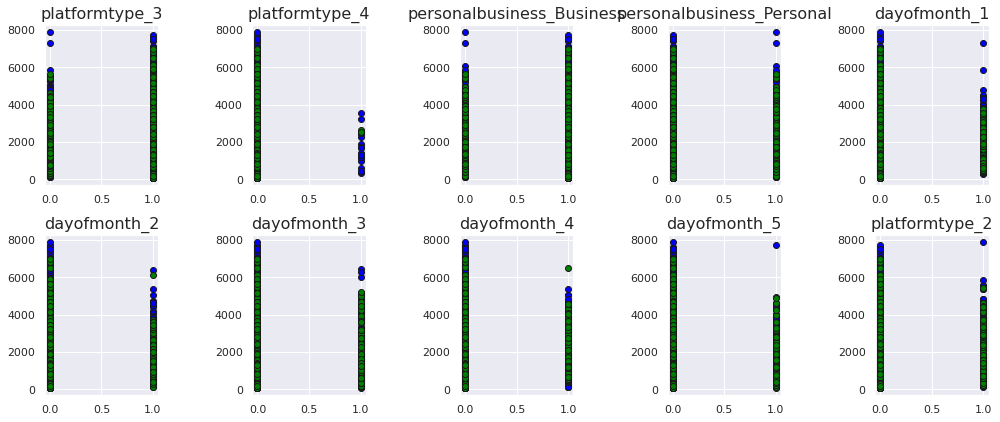

In [66]:
fig, axs = plt.subplots(2,5, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()
for index, column in enumerate(X_train.columns[10:20]):
    axs[index-1].set_title("{}".format(column),fontsize=16)
    axs[index-1].scatter(x=X_train[column],y=y_train,color='blue',edgecolor='k',label='Training')
    axs[index-1].scatter(x=X_test[column],y=y_test,color='green',edgecolor='k',label='Testing')
fig.tight_layout(pad=1)

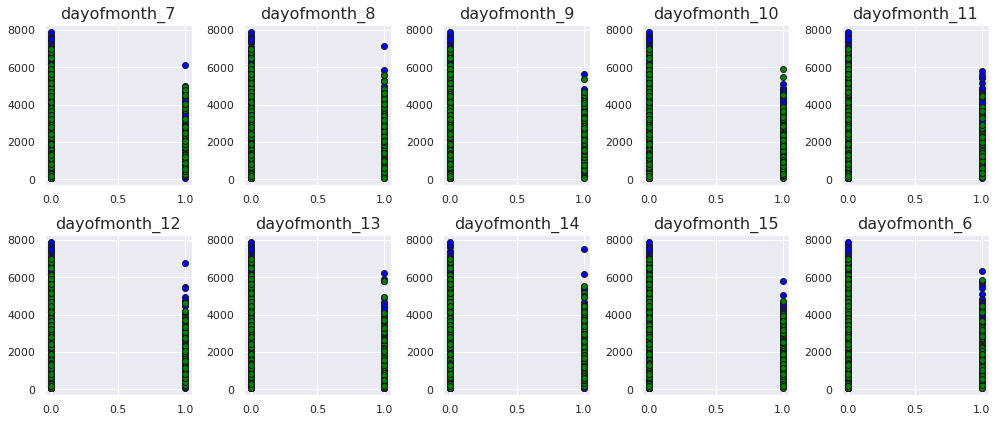

In [67]:
fig, axs = plt.subplots(2,5, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()
for index, column in enumerate(X_train.columns[20:30]):
    axs[index-1].set_title("{}".format(column),fontsize=16)
    axs[index-1].scatter(x=X_train[column],y=y_train,color='blue',edgecolor='k',label='Training')
    axs[index-1].scatter(x=X_test[column],y=y_test,color='green',edgecolor='k',label='Testing')
fig.tight_layout(pad=1)

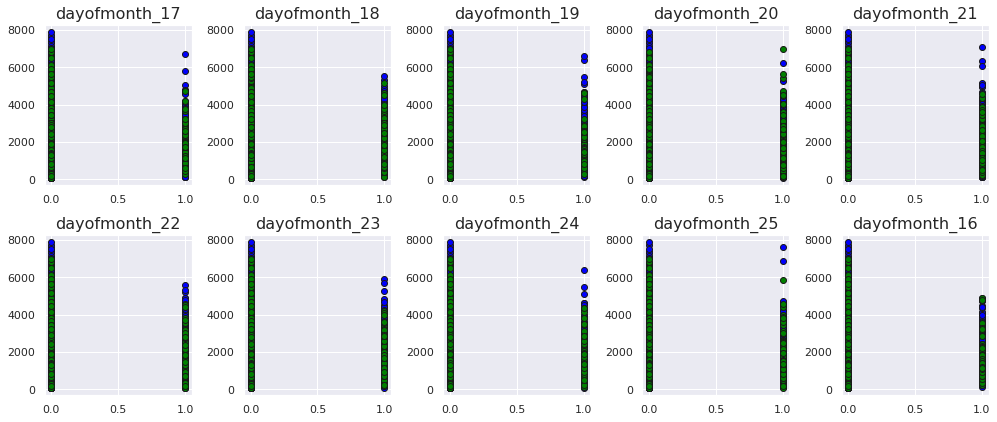

In [68]:
fig, axs = plt.subplots(2,5, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()
for index, column in enumerate(X_train.columns[30:40]):
    axs[index-1].set_title("{}".format(column),fontsize=16)
    axs[index-1].scatter(x=X_train[column],y=y_train,color='blue',edgecolor='k',label='Training')
    axs[index-1].scatter(x=X_test[column],y=y_test,color='green',edgecolor='k',label='Testing')
fig.tight_layout(pad=1)

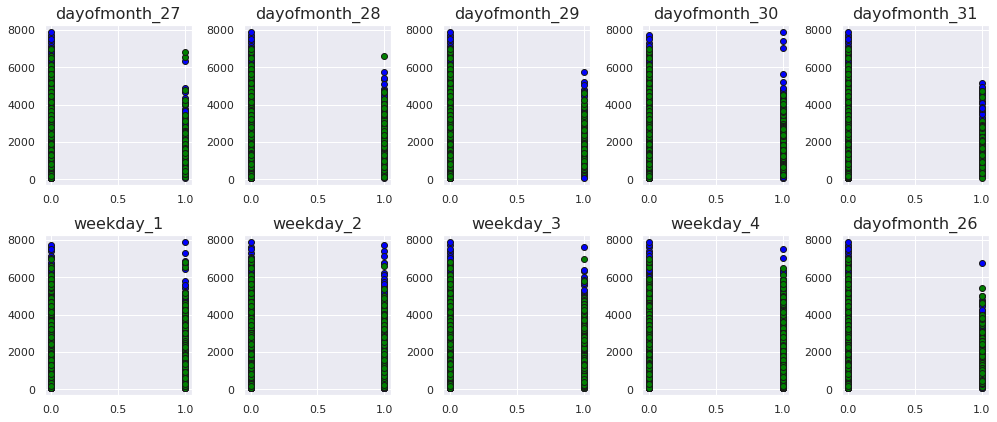

In [69]:
fig, axs = plt.subplots(2,5, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()
for index, column in enumerate(X_train.columns[40:50]):
    axs[index-1].set_title("{}".format(column),fontsize=16)
    axs[index-1].scatter(x=X_train[column],y=y_train,color='blue',edgecolor='k',label='Training')
    axs[index-1].scatter(x=X_test[column],y=y_test,color='green',edgecolor='k',label='Testing')
fig.tight_layout(pad=1)

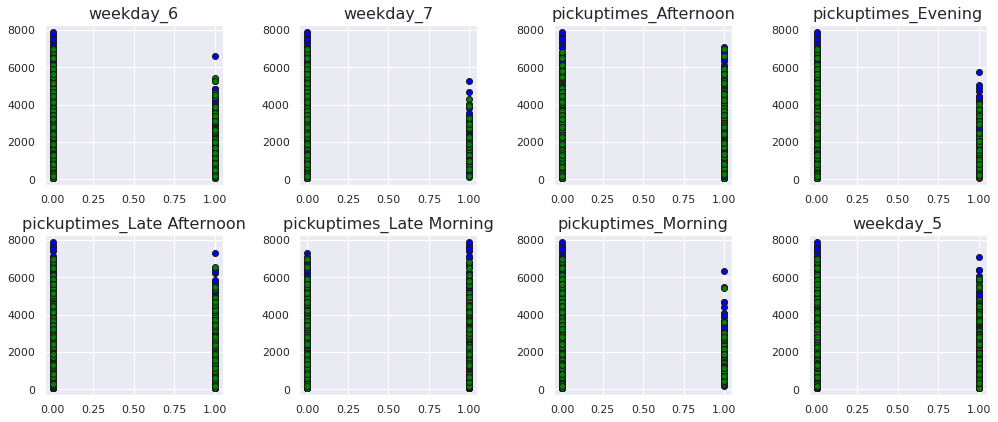

In [70]:
fig, axs = plt.subplots(2,4, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()
for index, column in enumerate(X_train.columns[50:58]):
    axs[index-1].set_title("{}".format(column),fontsize=16)
    axs[index-1].scatter(x=X_train[column],y=y_train,color='blue',edgecolor='k',label='Training')
    axs[index-1].scatter(x=X_test[column],y=y_test,color='green',edgecolor='k',label='Testing')
fig.tight_layout(pad=1)

##Modelling

### Model 1 - Multiple Linear Regression

Multiple linear regression is used to explain a dependent variable's behaviour by fitting many independent variables in a linear equation. While this model is easy to interpret, it assumes a linear relationship between the variables which may not necessarily be true.

In [71]:
# Create LinearRegression object
linear_model = LinearRegression()

# Fit a linear regression model
linear_model.fit(X_train, y_train)

# Predicting test results
y_pred_mlr = linear_model.predict(X_test)

# Calculate and print metrics
print("Training MSE:", metrics.mean_squared_error(training_outputs, linear_model.predict(training_features)))
print("Validation MSE: ", metrics.mean_squared_error(y_test,y_pred_mlr))

print("\nTraining RMSE:", np.sqrt(metrics.mean_squared_error(training_outputs, linear_model.predict(training_features))))
print("Validation RMSE:", np.sqrt(metrics.mean_squared_error(y_test,y_pred_mlr)))

Training MSE: 588773.509566468
Validation MSE:  588183.0217128281

Training RMSE: 767.3157821695497
Validation RMSE: 766.9309106515581


### Model 2 - Decision Tree

A decision tree is a relatively simple model that tests conditional outcomes of the data, with each outcome splitting into branches based on the "most significant splitter." Decision trees are easy to intepret and do not assume a linear relationship (unlike multiple linear regression), however, it risks over-fitting the data.


In [72]:
# Create DecisionTreeRegressor object
regression_tree = DecisionTreeRegressor(max_depth=5)

# Fit a regression tree model
regression_tree.fit(X_train, y_train)

# Predicting test results
y_pred_reg_tree = regression_tree.predict(X_test)


print("Training MSE:", metrics.mean_squared_error(training_outputs, regression_tree.predict(training_features)))
print("Validation MSE:", metrics.mean_squared_error(y_test, y_pred_reg_tree))

print("\nTraining RMSE:", np.sqrt(metrics.mean_squared_error(training_outputs, regression_tree.predict(training_features))))
print("Validation RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg_tree)))

Training MSE: 586700.8504264638
Validation MSE: 615467.8832600142

Training RMSE: 765.9640007379353
Validation RMSE: 784.5176118227138


### Model 3 - Bagging

Otherwise known as Bootstrap Aggregation, Bagging is a homogeneous ensemble method that combines the predictions of multiple weaker models to make a more accurate prediction. By bagging decision trees, there is a smaller chance of over-fitting.

In [73]:
# Set weaker decision tree model as a base model
d_tree = DecisionTreeRegressor(max_depth=5)

# Instantiate BaggingRegressor model with a decision tree as the base model
bag_reg = BaggingRegressor(base_estimator = d_tree)

# Fit model
bag_reg.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=5,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True

In [74]:
# Test model
y_pred = bag_reg.predict(X_test)

# Calculate and print RMSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

RMSE:  768.7741402672677


### Model 4 - Random Forest

Random forest models are considered to be an improvement on bagging decision trees. A random forest model combines decision trees in such a way that their predictions are uncorrelated to each other, thereby improving the accuracy of the final prediction.

#### Random Forest Model with no Hyperparameter Tuning


In [75]:
# Create RandomForestRegressor object
random_forest = RandomForestRegressor(n_estimators = 7)

# Fit a random foreset model
random_forest.fit(X_train, y_train)

# Predicting test results
y_pred_forest = random_forest.predict(X_test)

print("Training MSE:", metrics.mean_squared_error(training_outputs, random_forest.predict(training_features)))
print("Validation MSE:", metrics.mean_squared_error(y_test, y_pred_forest))

print("\nTraining RMSE:", np.sqrt(metrics.mean_squared_error(training_outputs, random_forest.predict(training_features))))
print("Validation RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_forest)))

Training MSE: 235756.06926913676
Validation MSE: 662536.2206795679

Training RMSE: 485.5471854198485
Validation RMSE: 813.9632796874611


#### Hyperparameter tuning - Random Search

RandomizedSearchCV is used to define a grid of hyperparameter ranges and then randomly sample from this grid while performing K-fold cross validation with each combination.

In [0]:
# Create random forest object
forest1 = RandomForestRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [77]:
# 3 fold cross validation, search across 30 different combinations, use all available cores, find MSE
rf_random = RandomizedSearchCV(estimator = forest1, param_distributions = param_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = 'neg_mean_squared_error')

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [78]:
# Observing how RMSE changes for each parameter configuration
cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

775.177538713211 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 23}
835.6850505305798 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 1}
775.0473235538454 {'n_estimators': 110, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 23}
766.2835968244278 {'n_estimators': 65, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 23}
914.0103207536598 {'n_estimators': 155, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 1}
770.5260852467785 {'n_estimators': 155, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 23}
924.5222872535279 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
777.4416022297044 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}
837.0470334328386 {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 1}
913.4343258000392 {'n_estimators': 110, 'min_samples_split': 

In [79]:
# Predicting test results from the best random model
random_best = rf_random.best_estimator_.predict(X_test)

# Calculate and print RMSE for best random search random forest model
random_final_mse = math.sqrt(metrics.mean_squared_error(y_test, random_best))
print("RMSE of best random forest model: ", random_final_mse)

RMSE of best random forest model:  759.0827426804118


In [0]:
# Pickling of random search random forest model
model_save_path = "random_forest_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(rf_random,file)

#### Grid Search

In [0]:
# Create random forest object 
forest2 = RandomForestRegressor()

# Parameter grid
param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(forest2, param_grid, cv=10, scoring='neg_mean_squared_error')

# Fit to model
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [0]:
# RMSE for each parameter configuration
cvres = grid_search_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

806.2120393271638 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 10}
794.5959637017316 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 25}
772.2565914112691 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 10}
766.718746892016 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 25}
801.3959282500199 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 10}
777.3111078566376 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 25}
790.8382675497203 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 10}
769.4543041157848 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 25}
801.9862622007064 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 10}
777.3229931448757 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 25}
792.2510731423938 {'bootstrap': True, 'max_depth': No

In [0]:
# Predicting test results from best grid search random forest model
grid_best= grid_search_forest.best_estimator_.predict(X_test)

# Calculate and print RMSE for model
grid_final_mse = math.sqrt(metrics.mean_squared_error(y_test, grid_best))
print("RMSE of best grid search random forest model: ", grid_final_mse)

RMSE of best grid search random forest model:  780.3178688551964


#### Random Forest Feature Importance

Identifying which features are more useful in predicting the target value allows us to draw insights the data and the model. Feature importance is calculated on the random forest model without hyperparameter tuning.

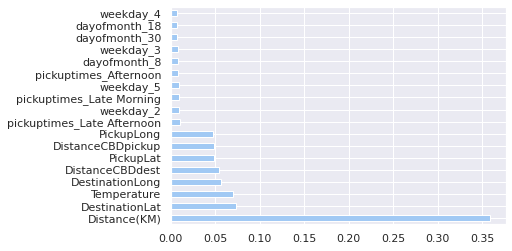

In [81]:
feat_importances = pd.Series(random_forest.feature_importances_, training_features.columns)
feat_importances.nlargest(18).plot(kind='barh')

Distance is the most influential predictor of travel time, as can be expected.

 The location of the destination, including how far it is from the CBD, seems to be very important. This could be due to traffic. 

It is interesting that temperature seems to play a large role in predicting travel time.

In [83]:
# Selecting only features with a significance level of above 0.005
best_features = feat_importances[feat_importances[:] >= 0.005]
best_features

PickupLat                     0.048170
PickupLong                    0.047203
DestinationLat                0.072934
DestinationLong               0.056316
Distance(KM)                  0.358329
Temperature                   0.070211
DistanceCBDpickup             0.048092
DistanceCBDdest               0.054236
dayofmonth_7                  0.006436
dayofmonth_8                  0.007704
dayofmonth_9                  0.005341
dayofmonth_11                 0.005109
dayofmonth_12                 0.005029
dayofmonth_13                 0.005538
dayofmonth_14                 0.005536
dayofmonth_17                 0.005518
dayofmonth_18                 0.006764
dayofmonth_21                 0.005954
dayofmonth_28                 0.005645
dayofmonth_30                 0.007152
weekday_1                     0.006041
weekday_2                     0.009354
weekday_3                     0.007567
weekday_4                     0.006566
weekday_5                     0.008874
pickuptimes_Afternoon    

### Model 5 - Stacking (ensemble)


Stacking combines all the models that have been used to provide a better predictive performance compared to a single model. This method trains itself based on the output of multiple heterogeneous models.

In [0]:
# Selecting models to combine
used_models = [("LM",linear_model),("DTR",regression_tree),("RF",random_forest)]

# Here we choose to use a simple linear regression 
meta_learner_reg = LinearRegression()

# Create StackingRegressor class
stack_reg = StackingRegressor(used_models, meta_learner_reg)

# Fit stacking model
stack_reg.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('LM',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('DTR',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=5,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,

In [0]:
# Make prediction 
y_pred_stack = stack_reg.predict(X_test)

# Calculate and print metrics
print("Training MSE:", metrics.mean_squared_error(training_outputs, stack_reg.predict(training_features)))
print("Validation MSE:", metrics.mean_squared_error(y_test, y_pred_stack))
print("\nTraining RMSE:", np.sqrt(metrics.mean_squared_error(y_train, stack_reg.predict(X_train))))
print("Validation RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_stack)))

Training MSE: 470233.2569395628
Validation MSE: 602356.8488242544

Training RMSE: 661.2066900005149
Validation RMSE: 776.1165175566452


##Performance evaluation

Make a dataframe to store information about predictions

In [0]:
data = pd.DataFrame()
data['Actual'] = y_test
data['MLR'] = y_pred_mlr
data['Decision Tree'] = y_pred_reg_tree
data['Random Forest'] = y_pred_forest
data['Best Random Forest'] = random_best
data['Best Grid search'] = grid_best

data.head()

,Actual,MLR,Decision Tree,Random Forest,Best Random Forest,Best Grid search
Order No,,,,,,
Order_No_22386,1480,1512.934470,1426.136546,1543.285714,1620.270415,1522.817256
Order_No_24768,2574,1594.973684,1653.250627,1454.142857,1712.007336,1485.390040
Order_No_2350,485,953.825623,881.698184,924.428571,1288.528379,1034.698899
Order_No_1963,1539,958.073833,881.698184,1174.714286,1032.810187,1044.015086
Order_No_1315,2307,2465.827001,2720.527331,3513.428571,2342.312234,2375.484341


Plotting the predictions

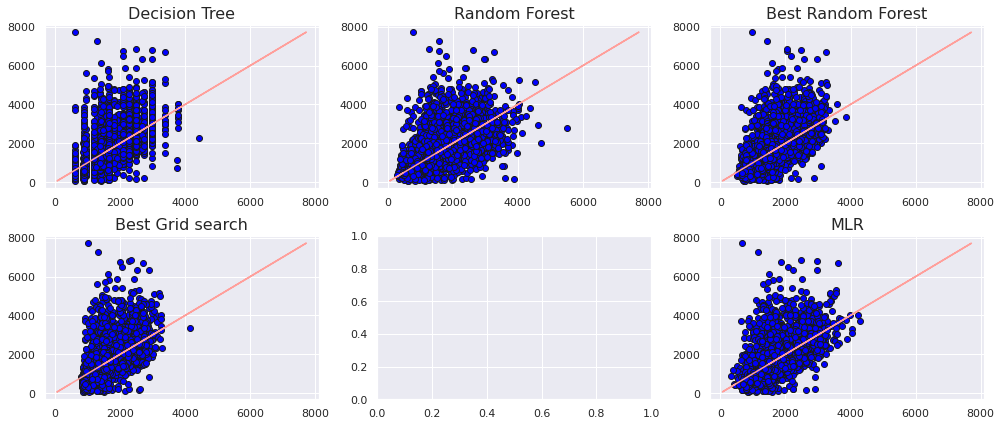

In [0]:
# plot scatter graph of y_test and y_predict for models
fig, axs = plt.subplots(2,3, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()
for index, column in enumerate(data.columns[1:]):
    axs[index-1].set_title("{}".format(column),fontsize=16)
    axs[index-1].scatter(x=data[column],y=data['Actual'],color='blue',edgecolor='k')
    axs[index-1].plot(data['Actual'],data['Actual'],'r')
fig.tight_layout(pad=1)
# choose the best model

# saving the model with Pickle

# Restoring the model with Pickle

## Model analysis

In [0]:
# How can model help Sendy?

# How did modelling the traffic help with an accurate model?

#Conclusion


 Did we answer the problem statement?

 Did we create a viable equation of value?